In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


Cannot import mxnet.


In [2]:
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

In [3]:
prep_id = 2
# input_img_version = 'grayL500H0'
input_img_version = 'grayDefault'

In [4]:
from skimage.filters import gabor_kernel

In [5]:
# def compute_feats(image, kernels):
#     feats = np.zeros((len(kernels), 2), dtype=np.double)
#     for k, kernel in enumerate(kernels):
#         filtered = ndi.convolve(image, kernel, mode='wrap')
#         feats[k, 0] = filtered.mean()
#         feats[k, 1] = filtered.var()
#     return feats

In [6]:
gabor_params = {
 "param_id": "redNissl", 
 "min_wavelen": 5.0, 
 "max_wavelen": 130.0, 
 "freq_step": 1.5, 
 "theta_interval": 16, 
 "bandwidth": 2
}

In [7]:
theta_interval = gabor_params['theta_interval']
n_angle = int(180/theta_interval)
freq_step = gabor_params['freq_step']
freq_max = 1./gabor_params['min_wavelen']
freq_min = 1./gabor_params['max_wavelen']
bandwidth = gabor_params['bandwidth']
n_freq = int(np.log(freq_max/freq_min)/np.log(freq_step)) + 1
frequencies = freq_max/freq_step**np.arange(n_freq)
angles = np.arange(0, n_angle)*np.deg2rad(theta_interval)

kernels = [gabor_kernel(f, theta=t, bandwidth=bandwidth) for f in frequencies for t in angles]
kernels = map(np.real, kernels)

n_kernel = len(kernels)

print 'num. of kernels: %d' % (n_kernel)
print 'frequencies:', frequencies
print 'wavelength (pixels):', 1/frequencies

max_kern_size = np.max([kern.shape[0] for kern in kernels])
print 'max kernel matrix size:', max_kern_size

num. of kernels: 99
frequencies: [ 0.2         0.13333333  0.08888889  0.05925926  0.03950617  0.02633745
  0.0175583   0.01170553  0.00780369]
wavelength (pixels): [   5.            7.5          11.25         16.875        25.3125
   37.96875      56.953125     85.4296875   128.14453125]
max kernel matrix size: 243


In [8]:
biases = np.array([k.sum() for k in kernels])
mean_bias = biases.mean()
kernels = [k/k.sum()*mean_bias for k in kernels]

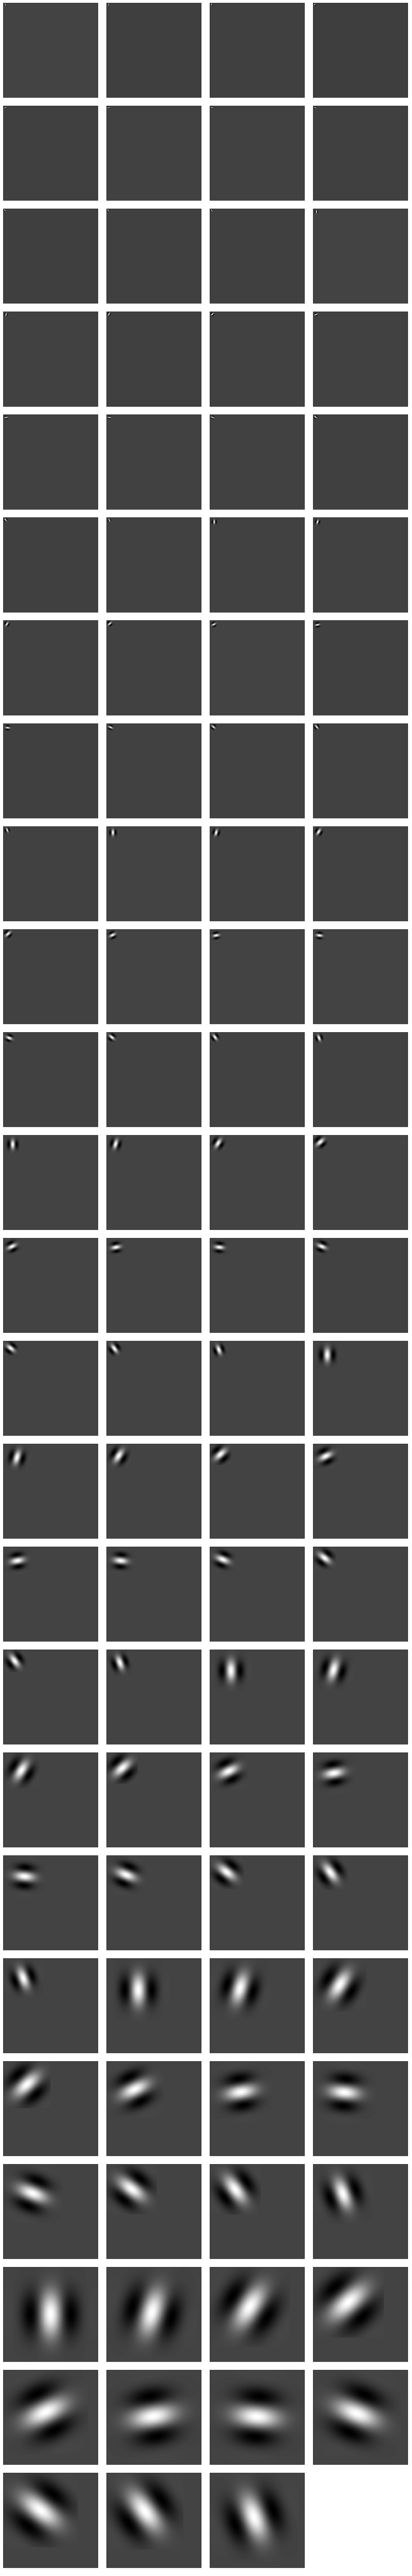

In [9]:
display_images_in_grids(kernels, nc=4, cmap=plt.cm.gray, maintain_shape=True)

In [9]:
stack = 'MD589'

In [10]:
img = DataManager.load_image_v2(stack=stack, section=134, prep_id=2, version='gray')
mask = DataManager.load_image_v2(stack=stack, section=134, prep_id=2, version='mask', resol='thumbnail')

In [11]:
xmin_tb, xmax_tb, ymin_tb, ymax_tb = bbox_2d(mask)
xmin = xmin_tb * 32
xmax = (xmax_tb + 1) * 32
ymin = ymin_tb * 32
ymax = (ymax_tb + 1) * 32

In [12]:
from scipy.signal import fftconvolve

Reference: https://github.com/mistycheney/MouseBrainAtlas/blob/43423b17c0dbcd0ef8ee22dbf9b92d44c2db7d2a/unused/2014/notebooks/process_CSHL_data.py

# Sample patches, compute features for those

In [13]:
win_id = 5

In [14]:
patch_size = windowing_settings[win_id]['patch_size']
half_size = patch_size / 2
stride = windowing_settings[win_id]['spacing']
# stride = 16
image_width, image_height = metadata_cache['image_shape'][stack]
grid_spec = (patch_size, stride, image_width, image_height)

sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

In [15]:
sec = 134

In [16]:
# Use grids only on mask.
t = time.time()
mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
sample_locations_roi = sample_locations[indices_roi]
print len(sample_locations_roi)

27714


locate patches: 0.01 seconds


In [17]:
patches = extract_patches_given_locations(img=img, locs=sample_locations_roi, patch_size=patch_size)

In [18]:
kernels_padded = np.array(pad_patches_to_same_size(kernels, keep_center=True, common_shape=(patch_size,patch_size)))
kernels_padded_flattened = kernels_padded.reshape((kernels_padded.shape[0], -1))

In [19]:
batch_size = 10000
sample_location_features_list = []
for b in range(0, len(patches), batch_size):
    print b
    feats = np.dot(kernels_padded_flattened, 
                                  np.reshape(patches[b:b+10000], (len(patches[b:b+10000]),-1)).T).T
    sample_location_features_list.append(feats)
sample_location_features = np.concatenate(sample_location_features_list)
del sample_location_features_list, feats

0
10000
20000


In [20]:
# from scipy.ndimage.interpolation import map_coordinates
# def resample_scoreamp(sparse_scores, sample_locations_roi, output_shape, downscale,
#                      patch_size, spacing):
#     """
#     Resample a sparse scoremap to generate a dense map.
#     """

#     w, h = output_shape
#     downscaled_grid_y = np.arange(0, h, downscale)
#     downscaled_grid_x = np.arange(0, w, downscale)
#     downscaled_ny = len(downscaled_grid_y)
#     downscaled_nx = len(downscaled_grid_x)

#     half_size = patch_size/2
#     f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
#     a = (sample_locations_roi - half_size)/spacing
#     f_grid[a[:,1], a[:,0]] = sparse_scores

#     yinterps = (downscaled_grid_y - half_size)/float(spacing)
#     xinterps = (downscaled_grid_x - half_size)/float(spacing)

#     points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
#     coord = np.c_[points_y.flat, points_x.flat]
#     f_interp = map_coordinates(f_grid, coord.T, order=1)
#     f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
    
#     return f_interp_2d

In [23]:
# for k in range(len(kernels)):
#     downscale = 8
#     q = resample_scoreamp(sample_location_features[:, k], sample_locations_roi, 
#                           output_shape=(image_width, image_height),
#                          downscale=downscale,
#                          patch_size=patch_size, 
#                           spacing=stride)
#     plt.matshow(q[1000:1200, 800:1000], cmap=plt.cm.jet);
#     plt.show()

In [128]:
# sample_location_features = []
# for i in range(n_kernel)[60:61]:
#     feats = convolve_per_proc(i, xmin, xmax, ymin, ymax)
#     sample_location_feats = feats[sample_locations_roi[:,1]-ymin, sample_locations_roi[:,0]-xmin]
#     sample_location_features.append(sample_location_feats)

In [117]:
# plt.figure(figsize=(20,20));
# plt.imshow(feats[600:1000, 1500:2000].astype(np.float32), cmap=plt.cm.jet);
# plt.show();

# Convolve full image to get features

In [49]:
def convolve_per_proc(i, xmin, xmax, ymin, ymax):
    """
    Args:
        i (int): the index of Gabor kernel
    """
    t = time.time()
    pf = fftconvolve(img[ymin: ymax+1, xmin: xmax+1], kernels[i], 'same').astype(np.half)
    sys.stderr.write('filtered kernel %d: %.2f s\n' % (i, time.time() - t))
    return pf

# def convolve_per_proc(i):
#     pf = fftconvolve(dm.image[ymin-dm.max_kern_size:ymax+1+dm.max_kern_size, 
#                               xmin-dm.max_kern_size:xmax+1+dm.max_kern_size], 
#                        dm.kernels[i], 'same').astype(np.half)
#     sys.stderr.write('filtered kernel %d\n'%i)
    
#     return pf[dm.max_kern_size:-dm.max_kern_size, dm.max_kern_size:-dm.max_kern_size]

In [31]:
feature_map = np.zeros((image_height, image_width, n_kernel), np.half)

MemoryError: 

In [23]:
t = time.time()

block_width, block_height = (5000, 5000) 

pool = Pool(NUM_CORES/4)
# features = pool.map(lambda i: convolve_per_proc(i, xmin, xmax, ymin, ymax), range(n_kernel)[:10])
# features = pool.map(lambda i: fftconvolve(img[ymin:ymax+1, xmin:xmax+1], kernels[i], 'same').astype(np.half), 
#                     range(n_kernel)[:1])


for y in range(ymin, ymax+1, block_height):
    for x in range(xmin, xmax+1, block_width):
        features = pool.map(lambda i: fftconvolve(img[ymin:ymin+block_height, xmin:xmin+block_width], 
                                                  kernels[i], 'same').astype(np.half), 
                            range(n_kernel))
features = np.reshape(features, (n_kernel, -1)).T
pool.close()
pool.join()

sys.stderr.write('Convolve: %.2f s\n' % (time.time() - t)) # one section, 148,160,449 patches, 900 s

Convolve: 17.85 s


# Rotate Features

In [22]:
def rotate_features(fs, n_freq, n_angle):
    """
    Rotate features, so that the max direction is at index 0.
    
    Args:
        fs ((n_patches, n_features)-ndarray): unrotated features
    """
    
    features_tabular = fs.reshape((fs.shape[0], n_freq, n_angle))
    max_angle_indices = features_tabular.max(axis=1).argmax(axis=-1)
    features_rotated = np.reshape([np.roll(features_tabular[i], -ai, axis=-1) 
                                    for i, ai in enumerate(max_angle_indices)], 
                                (fs.shape[0], n_freq * n_angle))
    return features_rotated

In [23]:
t = time.time()
print 'rotate features ...',

n_splits = 1000
pool = Pool(NUM_CORES/2)
features_rotated = pool.map(lambda feats: rotate_features(feats, n_freq, n_angle), 
                            np.array_split(sample_location_features, n_splits))
# features_rotated = pool.map(lambda feats: rotate_features(feats, n_freq, n_angle), 
#                             np.array_split(features, n_splits))
pool.close()
pool.join()
features_rotated = np.vstack(features_rotated)

print 'done in', time.time() - t, 'seconds'
# dm.save_pipeline_result(features_rotated, 'featuresRotated', 'npy')

rotate features ... done in 0.51145195961 seconds


# Compute textons

In [24]:
t = time.time()
print 'loading features data ...',

# features_rotated = dm.load_pipeline_result('featuresRotated', 'npy')
# features_rotated = dm.load_pipeline_result('featuresRotated')

print 'done in', time.time() - t, 'seconds'

t = time.time()
print 'quantize feature vectors ...',

n_texton = 100
    
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=n_texton, batch_size=1000)
kmeans.fit(features_rotated[::10])
centroids = kmeans.cluster_centers_

from scipy.cluster.hierarchy import fclusterdata
cluster_assignments = fclusterdata(centroids, 1.15, method="complete", criterion="inconsistent")
# cluster_assignments = fclusterdata(centroids, 80., method="complete", criterion="distance")

reduced_centroids = np.array([centroids[cluster_assignments == i].mean(axis=0) for i in set(cluster_assignments)])

n_reduced_texton = len(reduced_centroids)
print n_reduced_texton, 'reduced textons'

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=n_reduced_texton, batch_size=1000, init=reduced_centroids)
# kmeans.fit(features_rotated_pca)
kmeans.fit(features_rotated)
final_centroids = kmeans.cluster_centers_
# labels = kmeans.labels_

# dm.save_pipeline_result(reduced_centroids, 'textons', 'npy')

loading features data ... done in 0.00103902816772 seconds
quantize feature vectors ... 10 reduced textons


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3


In [25]:
vq_params = {
 "param_id": "blueNissl", 
 "n_texton": 14, 
 "n_sample": 10000, 
 "n_iter": 5
}

# Assign features to textons; generate texton map.

In [26]:
print 'loading centroids and features ...',
t = time.time()

# centroids = dm.load_pipeline_result('textons')
centroids = final_centroids

# features_rotated = dm.load_pipeline_result('featuresRotated')
print 'done in', time.time() - t, 'seconds'

n_texton = len(centroids)

print 'assign textons ...',
t = time.time()

from scipy.spatial.distance import cdist

# def first_last_tuples_distribute_over(first_sec, last_sec, n_host):
#     secs_per_job = (last_sec - first_sec + 1)/float(n_host)
#     first_last_tuples = [(int(first_sec+i*secs_per_job), int(first_sec+(i+1)*secs_per_job-1) if i != n_host - 1 else last_sec) for i in range(n_host)]
#     return first_last_tuples

# label_list = []
# for f, l in first_last_tuples_distribute_over(0, len(features_rotated), 3):
#     print f, l
#     D = cdist(features_rotated[f:l+1, :20], centroids[:, :20])
#     labels = np.argmin(D, axis=1)
#     label_list.append(labels)
# labels = np.concatenate(label_list)

label_list = []
for i in range(0, len(features_rotated), 5000000):
    pool = Pool(NUM_CORES/2)
    Ds = pool.map(lambda fs: cdist(fs, centroids), np.array_split(features_rotated[i:i+5000000], 16))
    for D in Ds:
        label_list.append(np.argmin(D, axis=1))
    pool.close()
    pool.join()

labels = np.concatenate(label_list)

print 'done in', time.time() - t, 'seconds'

# textonmap = -1 * np.ones((image_height, image_width), dtype=np.int8)
# textonmap[dm.mask] = labels

# dm.save_pipeline_result(textonmap, 'texMap')

# colors = (np.loadtxt(dm.repo_dir + '/visualization/100colors.txt') * 255).astype(np.uint8)
# textonmap_viz = np.zeros((image_height, image_width, 3), np.uint8)
# textonmap_viz[mask] = colors[textonmap[mask]]
# dm.save_pipeline_result(textonmap_viz, 'texMapViz')

loading centroids and features ... done in 0.000249862670898 seconds
assign textons ... done in 0.348592042923 seconds


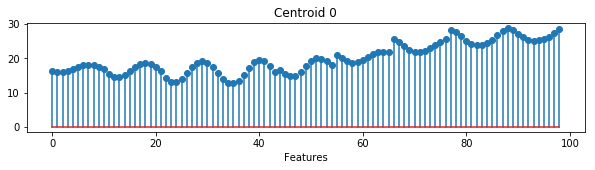

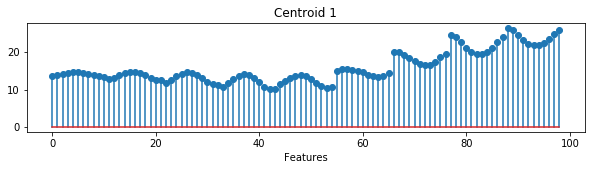

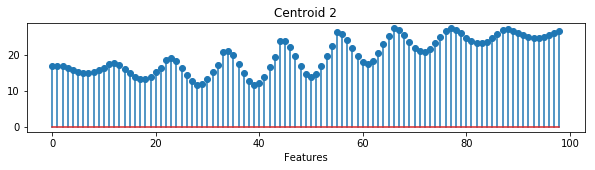

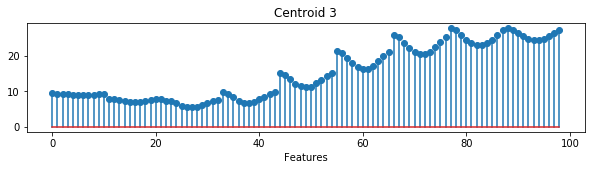

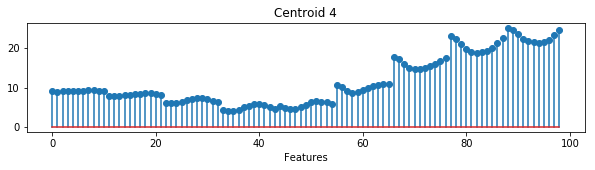

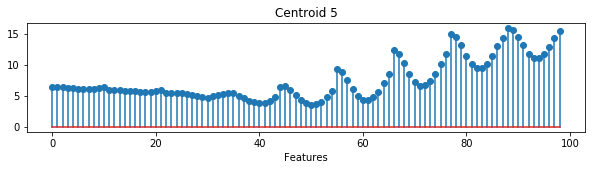

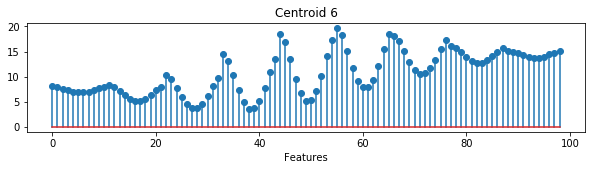

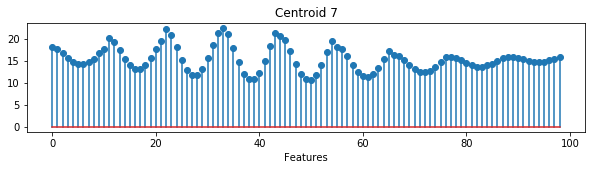

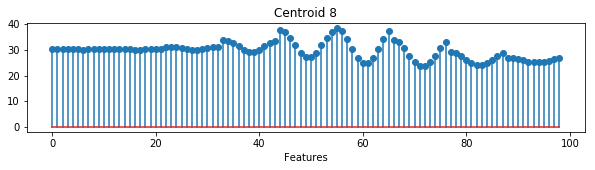

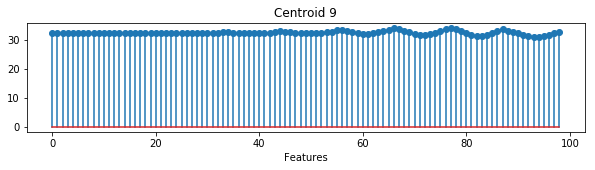

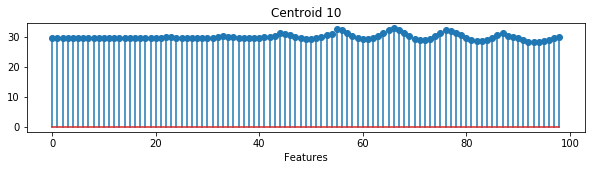

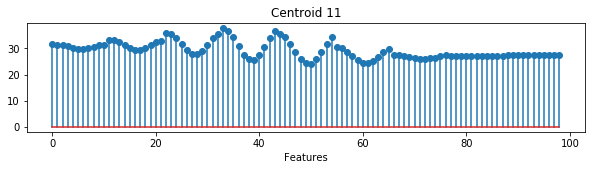

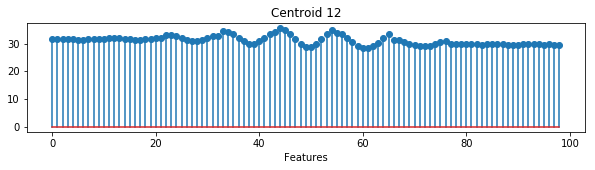

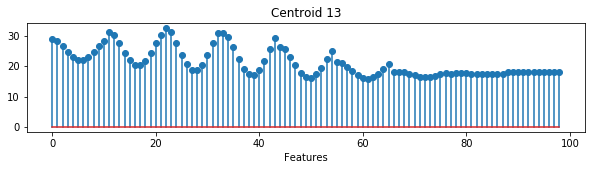

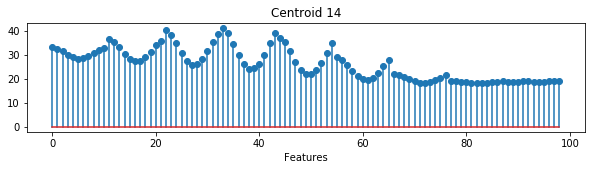

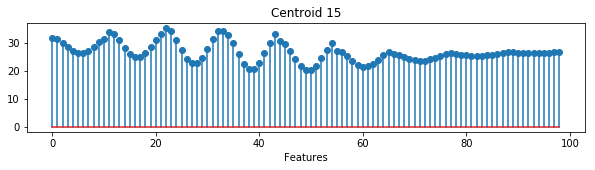

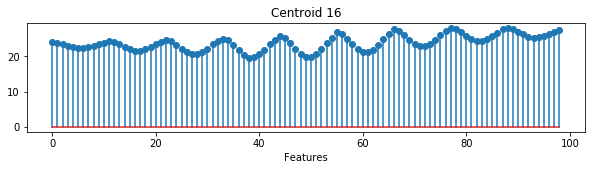

In [25]:
for i, c in enumerate(centroids):
    plt.figure(figsize=(10,2));
    plt.stem(range(n_kernel), c);
    plt.xlabel('Features');
    plt.title('Centroid %d' % i)
    plt.show();

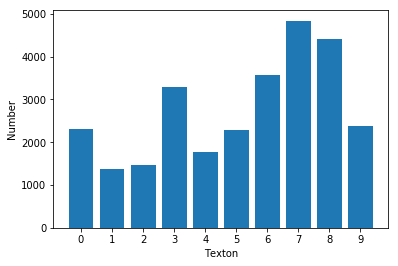

In [27]:
plt.bar(range(n_texton), np.bincount(labels));
plt.xlabel("Texton");
plt.ylabel("Number");
plt.xticks(range(n_texton));

In [28]:
# def convert_patch_to_segmentation():
#     segmentation = -1 * np.ones((image_height, image_width), np.int)
#     for i, (x, y) in enumerate(sample_locations_roi):
#         segmentation[y-half_size:y+half_size, x-half_size:x+half_size] = i
#     return segmentation

In [29]:
# segmentation = convert_patch_to_segmentation()

In [30]:
segmentation = -1 * np.ones((image_height, image_width), np.int)
for i, (x, y) in enumerate(sample_locations_roi):
    segmentation[y-half_size:y+half_size, x-half_size:x+half_size] = i

In [31]:
textonmap = -1 * np.ones((image_height, image_width), np.int)
for i, (x, y) in enumerate(sample_locations_roi):
    textonmap[y, x] = labels[i]

In [46]:
# From texton map to superpixel histogram map

# textonmap = dm.load_pipeline_result('texMap')
# segmentation = dm.load_pipeline_result('segmentation')
n_superpixels = segmentation.max() + 1

# centroids = dm.load_pipeline_result('textons')
n_texton = len(centroids)

t = time.time()

def texton_histogram_worker(i):
    # return np.bincount(textonmap[(segmentation == i)&(textonmap != -1)], minlength=n_texton)
    return np.bincount(textonmap[segmentation == i]+1, minlength=n_texton+1)[1:]

pool = Pool(NUM_CORES/2)
r = pool.map(texton_histogram_worker, range(n_superpixels)[5000:6000])
pool.close()
pool.join()

sp_texton_hist = np.array(r)
sp_texton_hist_normalized = sp_texton_hist.astype(np.float) / sp_texton_hist.sum(axis=1)[:, np.newaxis] # denom might be invalid

# dm.save_pipeline_result(sp_texton_hist_normalized, 'texHist')
sys.stderr.write('done in %.2f seconds\n' % (time.time() - t))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in divide
done in 99.50 seconds


In [ ]:
block_size = 4000

# def rotate_features(fs):

#     features_tabular = fs.reshape((fs.shape[0], dm.n_freq, dm.n_angle))
#     max_angle_indices = features_tabular.max(axis=1).argmax(axis=-1)

#     # t = time.time()
#     features_rotated = np.empty_like(features_tabular)

#     for a in range(dm.n_angle):
#         q = np.where(max_angle_indices == a)[0]
#         if len(q) == 0:
#             continue
#         v = np.roll(np.vstack(features_tabular[q]), -a, axis=-1)
#         features_rotated[q] = np.split(v, len(q), axis=0)

#     # sys.stderr.write('3, done in %f seconds\n' % (time.time() - t))
#     features_rotated = np.reshape(features_rotated, (fs.shape[0], dm.n_freq * dm.n_angle))

#     # del features_tabular, max_angle_indices
    
#     return features_rotated


for col, xmin in enumerate(range(dm.xmin, dm.xmax, block_size)):
    for row, ymin in enumerate(range(dm.ymin, dm.ymax, block_size)):

        xmax = xmin + block_size - 1
        ymax = ymin + block_size - 1

        print xmin, xmax, ymin, ymax

        # os.system(os.environ['GORDON_REPO_DIR']+'/pipeline/gabor_filter_part.py %s %s %d %d %d %d' % (args.stack_name, args.slice_ind, xmin, xmax, ymin, ymax))

        mask = dm.mask[ymin:ymax+1, xmin:xmax+1]

        perc = np.count_nonzero(mask) / float(mask.size)
        sys.stderr.write('masked pixels = %.2f, ' % perc)

        if perc == 0:
            continue

        t = time.time()
        sys.stderr.write('gabor filtering ...')

        features = Parallel(n_jobs=16, backend='threading')(delayed(convolve_per_proc)(i, xmin, xmax, ymin, ymax) for i in range(dm.n_kernel))
        h, w = features[0].shape
        # 99 x h x w

        sys.stderr.write('done in %f seconds\n' % (time.time() - t))

        # t = time.time()
        # sys.stderr.write('transpose ...')

        # # features = np.asarray(features).T  # n x 99
        # # features = np.roll(features, 0, -1)  # h x w x 99
        # features = np.reshape(features, (dm.n_kernel, h * w)).T  # n x 99
        # print features.shape

        # sys.stderr.write('done in %f seconds\n' % (time.time() - t))

        t = time.time()
        sys.stderr.write('mask ...')

        # features_masked = features[mask.flat]

        features_masked = np.asarray([features[i][mask] for i in range(dm.n_kernel)]).T # n x 99

        # bp.pack_ndarray_file(features_masked, '/scratch/yuncong/tmp.bp')

        # print features_masked.shape

        sys.stderr.write('done in %f seconds\n' % (time.time() - t))

        del features
        # sys.exit(0)

        # features_masked = bp.unpack_ndarray_file('/scratch/yuncong/tmp.bp')

        t = time.time()
        sys.stderr.write('rotate features ...')

        items_per_job = 1000   # 100 takes 144s, 500 takes 95s, 1000 takes 95s, 10000 takes 139s, 5000 takes 98s

        n = features_masked.shape[0]

        features_masked_rotated = Parallel(n_jobs=16)(delayed(rotate_features)(features_masked[si:ei]) 
                                for si, ei in zip(np.arange(0, n, items_per_job), np.arange(0, n, items_per_job) + items_per_job))

        features_masked_rotated = np.vstack(features_masked_rotated)

        sys.stderr.write('done in %f seconds\n' % (time.time() - t))

        t = time.time()
        sys.stderr.write('dumping ...')

        # (xmin, min(xmax, xmin+w-1), ymin, min(ymax, ymin+h-1))
        # bp.pack_ndarray_file(features_masked_rotated, '/scratch/yuncong/features_masked_rotated_r%d_c%d.bp' % (row, col))

        dm.save_pipeline_result(features_masked_rotated, 'featuresMaskedRotatedRow%dCol%d'%(row,col))

        del features_masked, features_masked_rotated

        sys.stderr.write('done in %f seconds\n' % (time.time() - t))    

